In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import json,sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
tqdm.pandas()
%matplotlib inline

In [23]:
# set a min_date for figures...
min_date = pd.Timestamp('2018-10-01').date()

In [24]:
feats = []
count = 0;
for line in open("../coverage/drcog_buildings.geojsonseq"):
    x = json.loads(line.strip())
    feats.append({
        'id':x['properties']["@id"],
        'date':x['properties']["@timestamp"],
        'user':x['properties']['@user'],
        'cset':x['properties']['@changeset']
    })
    count+=1
    if count%10000==0:
        sys.stderr.write("\r"+str(count))
print("Making Dataframe")
df = pd.DataFrame(feats)
print("Done")

20000

Making Dataframe
Done


In [25]:
print("\n\n DRCOG Objects: {:,}\n\n".format(len(df)))



 DRCOG Objects: 26,751




In [26]:
df['d'] = df['date'].progress_apply(lambda x: pd.Timestamp(x*1000000000).date())

100%|██████████| 26751/26751 [00:00<00:00, 358102.74it/s]


In [27]:
df.head(2)

,cset,date,id,user,d
0,64088041,1541094224,44460639,phidauex_imports,2018-11-01
1,63885330,1540516875,44460640,phidauex_imports,2018-10-26


In [28]:
df['id'].count(), df['id'].nunique(), df['user'].nunique()

(26751, 26751, 41)

Show the growth of some buildings...

In [29]:
gb_date = df.groupby('d')

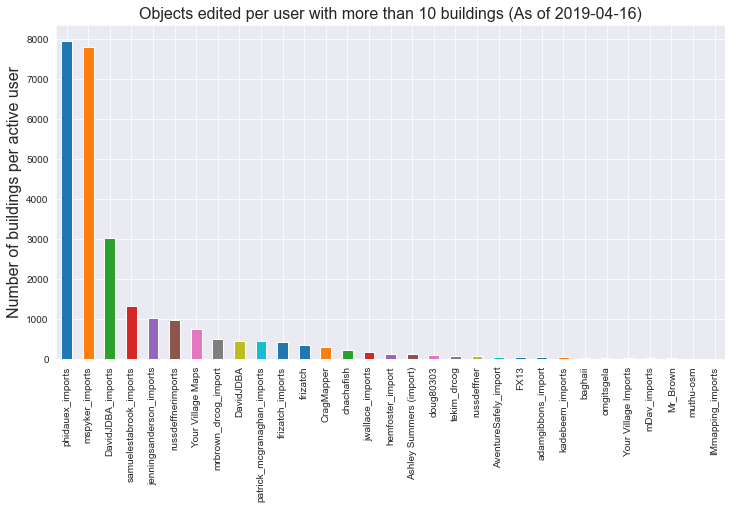

In [59]:
sns.set_style('darkgrid')
ax = df.user.value_counts()[df.user.value_counts()>10].plot(kind='bar', figsize=(12,8))
ax.set_ylabel("Number of buildings per active user",fontsize=16)
ax.set_title("Objects edited per user with more than 10 buildings (As of "+str(datetime.datetime.now().date())+")",fontsize=16);
ax.get_figure().subplots_adjust(bottom=0.3)
ax.get_figure().savefig('../docs/stats/objects-per-user.png')


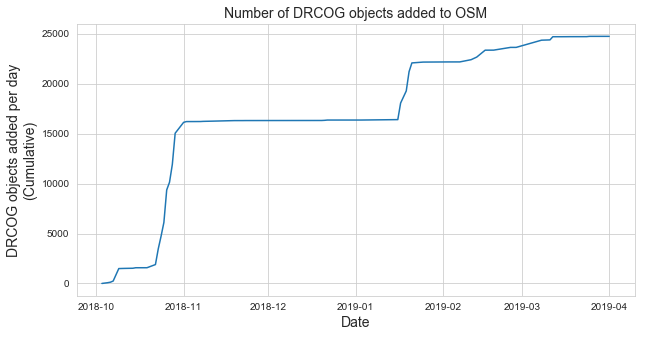

In [61]:
sns.set_style('whitegrid')
ax = df[df.d > min_date].groupby('d').aggregate({'id':'count'}).cumsum().plot(figsize=(10,5),legend=None)
ax.set_ylabel("DRCOG objects added per day\n(Cumulative)", fontsize=14)
ax.set_title("Number of DRCOG objects added to OSM",fontsize=14);
ax.set_xlabel("Date", fontsize=14)
ax.get_figure().savefig('../docs/stats/drcog-per-day.png');


In [100]:
# This is the most absurd rounding thing I've done in a long time, but it works...
# https://stackoverflow.com/questions/34539959/how-to-round-dates-to-week-starts-in-pandas

df['week'] = df.date.apply(
    lambda x: (pd.Timestamp(x*1000000000) - pd.to_timedelta(pd.Timestamp(x*1000000000).dayofweek,unit='d')).date())
df.head()


,cset,date,id,user,d,week
0,64088041,1541094224,44460639,phidauex_imports,2018-11-01,2018-10-29
1,63885330,1540516875,44460640,phidauex_imports,2018-10-26,2018-10-22
2,63885330,1540516875,44486952,phidauex_imports,2018-10-26,2018-10-22
3,63885132,1540515712,44486953,phidauex_imports,2018-10-26,2018-10-22
4,63965146,1540785816,44487623,phidauex_imports,2018-10-29,2018-10-29


In [101]:
combined_df = []
count =0;
for u,items in df[df.d > min_date].groupby('user'):
    if len(items)>0:
        new_df = items.groupby('week').aggregate({"id":'count'})
        new_df.columns=[u]
        if count==0:
            combined_df = new_df
        else:
            combined_df = combined_df.join(new_df, how='outer')
        count+=1


In [102]:
combined_df.head()

,Ashley Summers (import),AventureSafely_import,CragMapper,Dariaa_P,DavidJDBA,DavidJDBA_imports,Edward,FX13,IMmapping_imports,Your Village Maps,...,patrick_mcgranaghan_imports,phidauex,phidauex_imports,red_clover,russdeffner,russdeffnerimports,samuelestabrook_imports,sarahstude,tekim,tekim_drcog
week,,,,,,,,,,,,,,,,,,,,,
2018-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN
2018-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.0,32.0,NaN,NaN,NaN,NaN
2018-10-22,134.0,61.0,295.0,NaN,466.0,2267.0,NaN,57.0,12.0,NaN,...,24.0,NaN,3473.0,NaN,NaN,530.0,NaN,NaN,6.0,74.0
2018-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


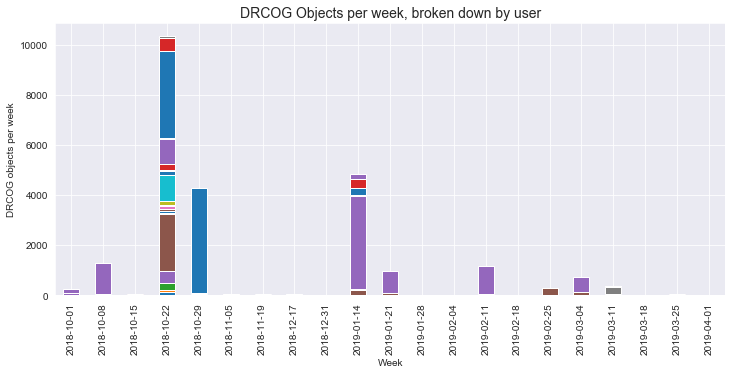

In [105]:
sns.set_style('darkgrid')
ax = combined_df.plot(kind='bar',stacked=True,figsize=(12,5),legend=False)
ax.set_ylabel("DRCOG objects per week")
ax.set_xlabel("Week")
ax.set_title("DRCOG Objects per week, broken down by user",fontsize=14);
ax.get_figure().savefig('../docs/stats/per-week-per-user.png')

# Make sure to get count for all buildings...

In [5]:
feats = []
count = 0;
for line in open("../coverage/all_buildings.geojsonseq"):
    x = json.loads(line.strip())
    feats.append({
        'id':x['properties']["@id"],
        'date':x['properties']["@timestamp"],
        'user':x['properties']['@user'],
        'cset':x['properties']['@changeset']
    })
    count+=1
    if count%10000==0:
        sys.stderr.write("\r"+str(count))
print("Making Dataframe")
all_buildings_df = pd.DataFrame(feats)
print("Done")

260000

Making Dataframe
Done


In [12]:
all_buildings_df['d'] = all_buildings_df['date'].progress_apply(lambda x: pd.Timestamp(x*1000000000).date())

100%|██████████| 269428/269428 [00:00<00:00, 466397.30it/s]


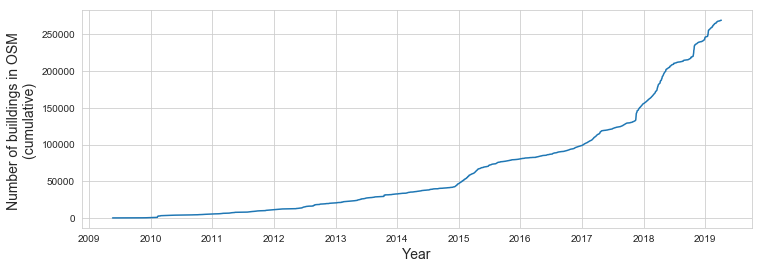

In [38]:
sns.set_style('whitegrid')
ax = all_buildings_df.groupby('d').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,4),legend=None)
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Number of builldings in OSM \n(cumulative) ",fontsize=14)
# ax.set_title('Cumulative count of all buildings in the Denver area',fontsize=14);
ax.get_figure().savefig('../docs/stats/buildings-in-drcog-area.png')

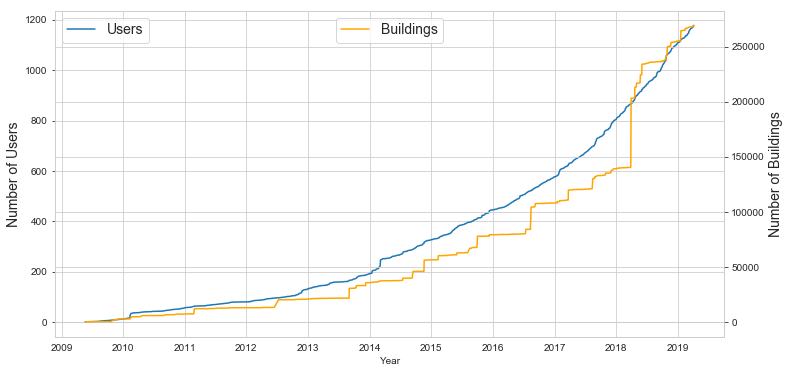

In [162]:
sns.set_style("whitegrid")
sums = all_buildings_df.groupby('user').aggregate(
    {'d':'first','id':'nunique'}
).reset_index().groupby('d').aggregate(
    {'user':'count','id':'sum'}
).cumsum()
ax = sums['user'].plot(figsize=(12,6))
ax2 = sums['id'].plot(ax=ax.twinx(),color='orange')
ax.legend(['Users'],fontsize=14)
ax2.legend(['Buildings'],fontsize=14,loc='upper center')
ax.set_ylabel("Number of Users",fontsize=14);
ax2.set_ylabel("Number of Buildings",fontsize=14);
ax.set_xlabel("Year")
ax.get_figure().savefig('../docs/stats/users-and-buildings-over-time.png')